# Final Project

### <span style="color:gray"> Violet Davis and Annie Friar </span>

### 
`Data Exploration`

---

In [1]:
# Import libraries

# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
NORMAL_IMAGE_PATH = 'Final_Project_Data/normal/' # Class as 1
GLIOMA_IMAGE_PATH = 'Final_Project_Data/glioma_tumor/' # Class as 2
MENINGIOMA_IMAGE_PATH = 'Final_Project_Data/meningioma_tumor/' # Class as 3
PITUITARY_IMAGE_PATH = 'Final_Project_Data/pituitary_tumor/' # Class as 4

2023-10-30 11:53:41.691330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset


Sample of normal images in data:


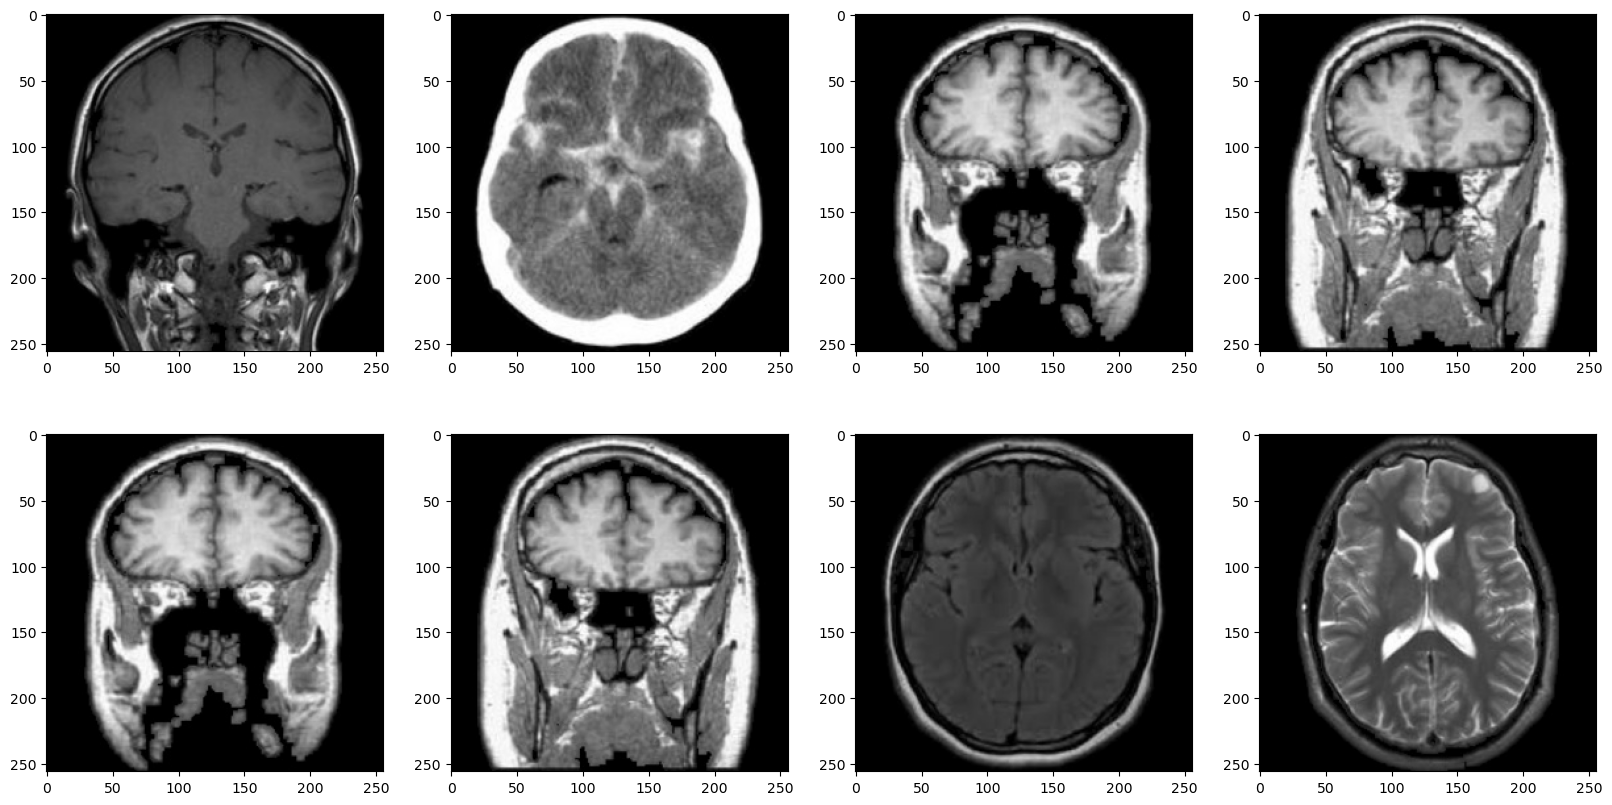

In [2]:
# read image
indx=0
images = []
labels = []

labels_index = 0

print('Sample of normal images in data:')
for idx, img in enumerate(os.listdir(NORMAL_IMAGE_PATH)):
    img = load_img(
    NORMAL_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx, 1))
    labels_index = idx
    
normal_index = labels_index + 1
    
for idx, img in enumerate(os.listdir(GLIOMA_IMAGE_PATH)):
    img = load_img(
    GLIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+normal_index, 2))
    labels_index = idx
    
glioma_index = normal_index + labels_index + 1
    
for idx, img in enumerate(os.listdir(MENINGIOMA_IMAGE_PATH)):
    img = load_img(
    MENINGIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+glioma_index, 3))
    labels_index = idx
    
meningioma_index = glioma_index + labels_index + 1
    
for idx, img in enumerate(os.listdir(PITUITARY_IMAGE_PATH)):
    img = load_img(
    PITUITARY_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+meningioma_index, 4))

nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(images[indx])

---

In [3]:
type(images[0])

PIL.JpegImagePlugin.JpegImageFile

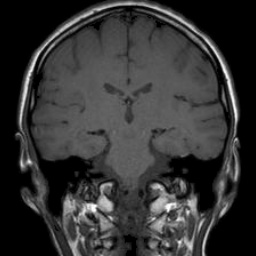

In [4]:
images[0]

In [5]:
labels = np.array(labels)

In [6]:
labels_df = pd.DataFrame(labels,
                   columns=['img_num', 'label'])

In [7]:
labels_df['label'].value_counts()

3    913
2    901
4    844
1    438
Name: label, dtype: int64

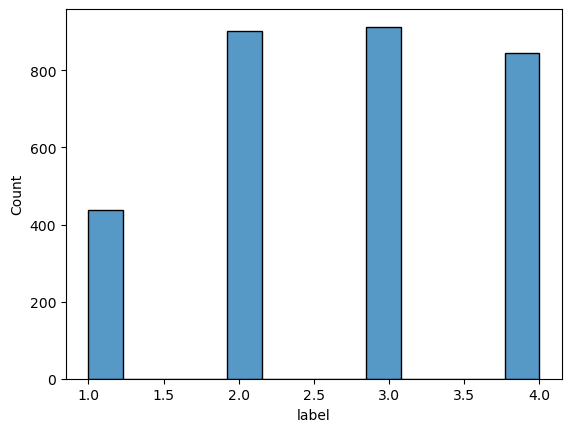

In [8]:
# histogram
sns.histplot(
    data=labels_df,
    stat="count",
    x = "label"
);

## From Cornelia's Diabetic Retinopathy Notebook:

As you can see from the histogram above, our dataset is very imbalanced, which is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for starters.

`Correct for data imbalance`

In [9]:
np.random.seed(1234)

normal = labels_df[labels_df['label'] == 1]
glioma = labels_df[labels_df['label'] == 2]
meningioma = labels_df[labels_df['label'] == 3]
pituitary = labels_df[labels_df['label'] == 4]

# randomly draw 400 images from each classes
temp_normal = list(np.random.choice(
    normal.img_num,
    size=400,
    replace=False
))

temp_glioma = list(np.random.choice(
    glioma.img_num,
    size=400,
    replace=False
))

temp_meningioma = list(np.random.choice(
    meningioma.img_num,
    size=400,
    replace=False
))


temp_pituitary = list(np.random.choice(
    pituitary.img_num,
    size=400,
    replace=False
))

print(temp_normal[141])
print(temp_normal[142])
print(temp_normal[143])

425
353
160


In [10]:
image_list = []
labels_list = []

for num in temp_normal:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_glioma:
    image_list.append(images[num])
    labels_list.append(labels[num])
    
for num in temp_meningioma:
    image_list.append(images[num])
    labels_list.append(labels[num])
    
for num in temp_pituitary:
    image_list.append(images[num])
    labels_list.append(labels[num])

In [11]:
print("Length of Image List: ", len(image_list))
print("Length of Labels List: ", len(labels_list))

Length of Image List:  1600
Length of Labels List:  1600


In [12]:
images_mini = []
y_mini = []

for img in image_list:
    
# transform image to array
    img = img_to_array(img)

    # append to images
    images_mini.append(img)
    
images_mini = np.stack(images_mini)
    
for label in labels_list:
    y_mini.append(label[1])
    
y_mini = np.array(y_mini)

In [13]:
images_mini.shape

(1600, 256, 256, 3)

In [14]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    # rescale image to [0,1], i.e., greyscale
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (960, 256, 256, 1)
y_train shape (960,)
X_val shape (320, 256, 256, 1)
y_val shape (320,)
X_test shape (320, 256, 256, 1)
y_test shape (320,)


In [16]:
validate_split = pd.DataFrame(y_train)

In [17]:
validate_split.value_counts()

3    249
1    243
4    237
2    231
dtype: int64

In [18]:
def get_avg_image_values(img_arr):
    vals = np.zeros((256, 256, 1))
    
    for img in img_arr:
        for w in range(len(img)):
            for l in range(len(img[w])):
                vals[w][l][0] += img[w][l][0]

    for w in range(len(vals)):
        for l in range(len(vals[w])):
            vals[w][l][0] = vals[w][l][0] / len(img_arr)
            
    return vals

In [20]:
test = X_train[:5]

In [21]:
avg_img = get_avg_image_values(test)

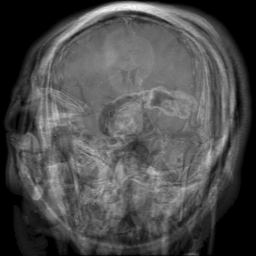

In [22]:
array_to_img(avg_img)